In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import numpy as np
import matplotlib.pyplot as plt

In [52]:
def compute_polys(dx, dy):
    n = len(dx)
    np1 = n + 1
    
    # Step 1
    a = np.empty(np1)
    a[0] = 3 * dy[0] / dx[0]
    a[1:-1] = 3 * dy[1:] / dx[1:] - 3 * dy[:-1] / dx[:-1]
    a[-1] = -3 * dy[-1] / dx[-1]
    
    # Step 2
    l = np.empty(np1)
    u = np.empty(n)
    z = np.empty(np1)
    l[0] = 2*dx[0]
    u[0] = 0.5
    z[0] = a[0] / l[0]
    for i in range(1, n):
        l[i] = 2*dx[i] + dx[i-1] * (2 - u[i-1])
        u[i] = dx[i] / l[i]
        z[i] = (a[i] - dx[i-1] * z[i-1]) / l[i]
    l[-1] = dx[-1] * (2 - u[-1])
    z[-1] = (a[-1] - dx[-1] * z[-2]) / l[-1]
    
    # Step 3
    c = np.empty(np1)
    c[-1] = z[-1]
    for j in range(n-1, -1, -1):
        c[j] = z[j] - u[j] * c[j+1]
        
    # Step 4
    b = dy / dx - dx * (c[1:] + 2*c[:-1]) / 3
    d = (c[1:] - c[:-1]) / (3*dx)
    
    return (np.vstack((
        np.concatenate(([0.0], b, [0.0])),
        np.concatenate(([0.0], c[:-1], [0.0])),
        np.concatenate(([0.0], d, [0.0]))
    )).T, a, z, u, l)

def compute_polys_rev(dx, dy, P, a, z, u, l, bP):
    n = len(dx)
    np1 = n + 1

    b = P[1:-1, 0]
    c = P[1:, 1]
    d = P[1:-1, 2]
    
    bb = np.array(bP[1:-1, 0])
    bc = np.array(bP[1:, 1])
    bd = np.array(bP[1:-1, 2])
    bc[-1] = 0.0
    
    # Step 4
    # d = (c[1:] - c[:-1]) / (3*dx)
    bdx = -d * bd / dx
    bc[1:] += bd / (3*dx)
    bc[:-1] += -bd / (3*dx)
    
    # b = dy / dx - dx * (c[1:] + 2*c[:-1]) / 3
    bdy = bb / dx
    bdx += -(dy/dx**2 + (c[1:]+2*c[:-1])/3) * bb
    bc[1:] += -dx * bb / 3
    bc[:-1] += -2 * dx * bb / 3
    
    # Step 3
    bu = np.zeros_like(u)
    bz = np.zeros_like(z)
    for j in range(n):
        # c[j] = z[j] - u[j] * c[j+1]
        bz[j] += bc[j]
        bc[j+1] += -bc[j] * u[j]
        bu[j] += -c[j+1] * bc[j]
    # c[-1] = z[-1]
    bz[-1] += bc[-1]
    
    # Step 2
    # z[-1] = (a[-1] - dx[-1] * z[-2]) / l[-1]
    ba = np.zeros_like(a)
    bl = np.zeros_like(l)
    ba[-1] += bz[-1] / l[-1]
    bdx[-1] += -z[-2] * bz[-1] / l[-1]
    bz[-2] += -dx[-1] * bz[-1] / l[-1]
    bl[-1] += -z[-1] * bz[-1] / l[-1]
    
    # l[-1] = dx[-1] * (2 - u[-1])
    bdx[-1] += (2 - u[-1]) * bl[-1]
    bu[-1] += -dx[-1] * bl[-1]

    for i in range(n-1, 0, -1):
        # z[i] = (a[i] - dx[i-1] * z[i-1]) / l[i]
        ba[i] += bz[i] / l[i]
        bl[i] += -z[i]*bz[i]/l[i]
        bdx[i-1] += -z[i-1] * bz[i] / l[i]
        bz[i-1] += -bz[i] * dx[i-1] / l[i]
        
        # u[i] = dx[i] / l[i]
        bdx[i] += bu[i] / l[i]
        bl[i] += -bu[i]*u[i]/l[i]

        # l[i] = 2*dx[i] + dx[i-1] * (2 - u[i-1])
        bdx[i] += 2*bl[i]
        bdx[i-1] += (2-u[i-1])*bl[i]
        bu[i-1] += -dx[i-1] * bl[i]
        
    # z[0] = a[0] / l[0]
    ba[0] += bz[0] / l[0]
    bl[0] += -z[0] * bz[0] / l[0]

    # l[0] = 2*dx[0]
    bdx[0] += 2*bl[0]
    
    # Step 1
    # a[0] = 3 * dy[0] / dx[0]
    bdy[0] += 3 * ba[0] / dx[0]
    bdx[0] += -a[0] * ba[0] / dx[0]

    # a[1:-1] = 3 * dy[1:] / dx[1:] - 3 * dy[:-1] / dx[:-1]
    bdy[1:] += 3 * ba[1:-1] / dx[1:]
    bdy[:-1] += -3 * ba[1:-1] / dx[:-1]
    bdx[1:] += -3 * dy[1:] * ba[1:-1] / dx[1:]**2
    bdx[:-1] += 3 * dy[:-1] * ba[1:-1] / dx[:-1]**2

    # a[-1] = -3 * dy[-1] / dx[-1]
    bdy[-1] += -3 * ba[-1] / dx[-1]
    bdx[-1] += -a[-1] * ba[-1] / dx[-1]
    
    return bdx, bdy

In [75]:
np.random.seed(42)
x = np.sort(np.random.uniform(1, 9, 61))
# x = np.linspace(1, 9, 61)
y = np.sin(x)
dx = np.diff(x)
dy = np.diff(y)

P, a, z, u, l = compute_polys(dx, dy)
bP = np.zeros_like(P)
# inds = ([3, 3, 3], [0, 1, 2])
inds = tuple(a.flatten() for a in np.indices(bP.shape))
bP[inds] = 1.0
# print(bP)
bx, by = compute_polys_rev(dx, dy, P, a, z, u, l, bP)
print(bx)
print(by)

[ 1.28980811e+03 -2.22976463e+03  2.69341982e+04 -1.11298075e+03
  3.95310058e+02  4.34157433e+01 -1.34470741e+03  2.57147574e+03
 -2.15984686e+04  1.16314723e+05 -1.58576924e+08  2.06161985e+05
 -9.57931987e+04  2.71866988e+05 -1.14069658e+05  8.49561849e+03
 -1.37441346e+04  1.67141444e+03 -2.78778041e+02  1.46733710e+03
 -2.83778904e+05  4.38007474e+04 -1.78458667e+06  5.82123928e+04
 -5.00518749e+03  3.55800787e+02 -8.73037580e+02  9.15339022e+01
  4.20081922e+01 -1.63329790e+02  1.04588434e+01 -3.46595020e+00
 -5.62679097e+01  7.84179808e+01  1.07977902e+03 -3.40718585e+02
  2.11597526e+02 -3.23525462e+04  5.89654497e+05 -1.17333607e+05
  1.38938094e+03  1.54834731e+03 -1.44484138e+02  1.36660716e+02
 -5.00406521e+01  4.39618743e+01 -5.16002223e+01  2.47775433e+02
 -5.31196355e+01  1.05190820e+01  2.44235932e+00  4.15668086e+00
 -2.23805772e+01  3.80903680e+01 -1.64307308e+02  2.85636418e+03
 -5.61043425e+03 -6.25826147e+03  1.98165891e+05 -7.30070785e+07]
[-2.30182004e+03  8.1239

In [76]:
value = dx
grad = bx

eps = 1e-8

for i in range(len(value)):
    value[i] += eps
    r = compute_polys(dx, dy)
    vp = np.sum(r[0][inds])

    value[i] -= 2*eps
    r = compute_polys(dx, dy)
    vm = np.sum(r[0][inds])
    value[i] += eps

    est = 0.5 * (vp - vm) / eps
    print(est, grad[i], est - grad[i], (est - grad[i]) / grad[i])

1289.8079148726538 1289.8081138127754 -0.00019894012166332686 -1.5424009163288951e-07
-2229.7648683888838 -2229.764628473579 -0.0002399153049736924 1.075966951444244e-07
26934.198467643 26934.198224338128 0.00024330487212864682 9.03330665728869e-09
-1112.9806807730347 -1112.9807493516491 6.857861444586888e-05 -6.161707153139743e-08
395.3100531361997 395.3100580309177 -4.894717960723938e-06 -1.2381971723929968e-08
43.4156390838325 43.415743270028806 -0.00010418619630314652 -2.399733102693865e-06
-1344.7075616568327 -1344.707412004998 -0.00014965183459025866 1.112895141755212e-07
2571.47585216444 2571.475739747868 0.00011241657193750143 4.3716753846771205e-08
-21598.468447336927 -21598.468576777464 0.00012944053742103279 -5.993042375245364e-09
116314.72334556747 116314.72320282017 0.0001427473034709692 1.227250510858011e-09
-158576925.75700638 -158576924.47627383 -1.2807325422763824 8.076411788828738e-09
206161.98562493082 206161.9853336204 0.0002913104253821075 1.4130171714765752e-09
-9

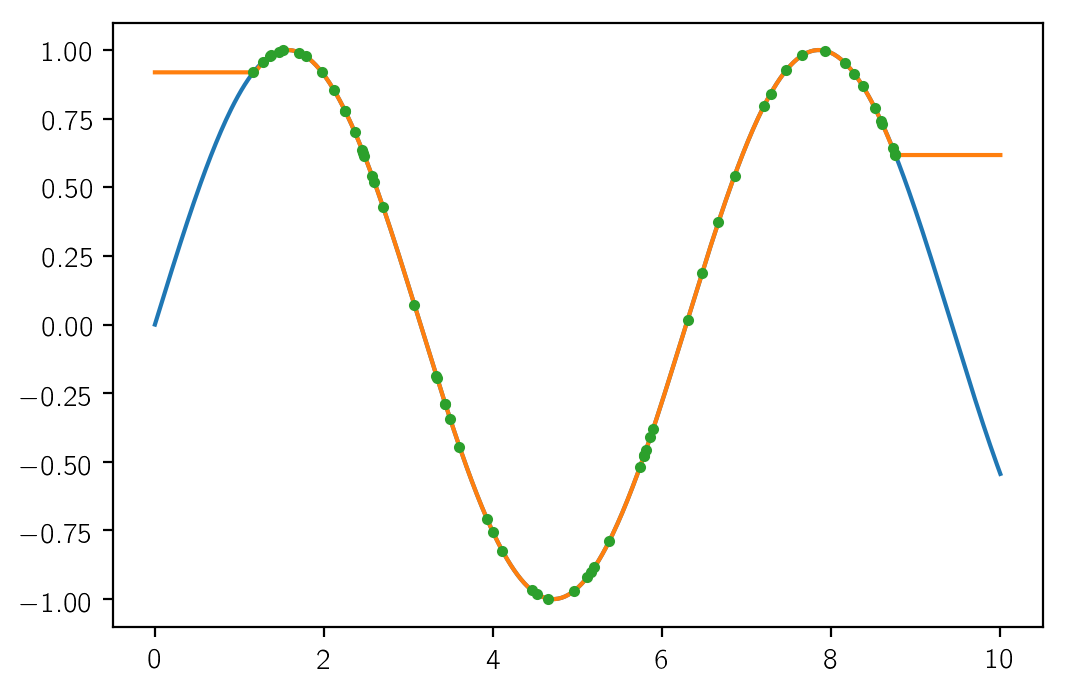

In [77]:
t = np.linspace(0, 10, 500)
inds = np.searchsorted(x, t)

xp = np.concatenate((x[:1], x, x[-1:]))
yp = np.concatenate((y[:1], y, y[-1:]))

poly = P[inds]
dd = t - xp[inds]
value = yp[inds] + poly[:, 0] * dd + poly[:, 1] * dd**2 + poly[:, 2] * dd**3

plt.plot(t, np.sin(t))
plt.plot(t, value)
plt.plot(x, y, ".")